## Importing libraries:

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import compute_class_weight, resample
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
import random
import os
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn.functional as F

## Setting a custom model that uses embeddings of the first [TAR] token instead of [CLS]:

In [2]:
class TARBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config, tokenizer):
        super().__init__(config)
        self.tokenizer = tokenizer

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        **kwargs
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            **kwargs
        )

        last_hidden_state = outputs.last_hidden_state
        tar_token_id = self.tokenizer.convert_tokens_to_ids('[TAR]')   # getting TAR token id
        tar_mask = (input_ids == tar_token_id).unsqueeze(-1)  # creating a mask based on the id
        tar_hidden_state = torch.sum(last_hidden_state * tar_mask, dim=1)
        logits = self.classifier(tar_hidden_state)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

## A class with the entire process:

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class RuBertCLSTrainer:
    def __init__(self,
                 train_path,
                 val_path,
                 test_path,
                 model_name='cointegrated/rubert-tiny2',   # setting the model
                 num_labels=3,
                 max_len=128,
                 batch_size=24,
                 lr=1e-5,
                 weight_decay=0.1,
                 epochs=10,
                 warmup_steps=300,
                 upsample=False,    # in case we need to balance the data
                 add_token=False,      # adding the TAR token to the vocab
                 new_token='[TAR]',
                 use_tar=False,
                 use_tar_emb=False,
                 random_state=42):

        self.random_state = random_state
        set_seed(self.random_state)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

        if use_tar_emb:                                                  # chosing a model (cls or tar embeddings)
            self.model = TARBertForSequenceClassification.from_pretrained(
                model_name,
                num_labels=num_labels,
                tokenizer=self.tokenizer
            )
        else:
            self.model = BertForSequenceClassification.from_pretrained(
                model_name,
                num_labels=num_labels
            )

        self.model.to(self.device)

        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.weight_decay = weight_decay
        self.warmup_steps = warmup_steps
        self.max_len = max_len

        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.upsample = upsample
        self.use_tar = use_tar
        self.use_tar_emb = use_tar_emb

        self.train_losses = []
        self.val_losses = []
        self.f1_scores = []
        self.f1_class_0 = []
        self.f1_class_2 = []

        if add_token:                           # adding a new token
            self.tokenizer.add_tokens([new_token])
            self.model.resize_token_embeddings(len(self.tokenizer))
            print(f"Added new token: {new_token}")
            print(self.tokenizer.convert_tokens_to_ids('[TAR]'))

        self._prepare_data()
        self._prepare_optimizer()

    def _prepare_data(self):
        train_df = pd.read_csv(self.train_path)
        val_df = pd.read_csv(self.val_path)
        test_df = pd.read_csv(self.test_path)

        if self.upsample:
            train_df = self._upsample_data(train_df)

        text_column = 'tar_sentence' if self.use_tar else 'sentence'       # which column to use - with or without [tar]
        print(f"Using column '{text_column}' for input texts.")

        self.train_dataset = self._tokenize_data(train_df[text_column], train_df['label'])
        self.val_dataset = self._tokenize_data(val_df[text_column], val_df['label'])
        self.test_dataset = self._tokenize_data(test_df[text_column], test_df['label'])

        g = torch.Generator()
        g.manual_seed(self.random_state)

        self.train_loader = DataLoader(
            self.train_dataset,
            sampler=RandomSampler(self.train_dataset, generator=g),
            batch_size=self.batch_size,
            num_workers=2
        )
        self.val_loader = DataLoader(self.val_dataset, sampler=SequentialSampler(self.val_dataset), batch_size=self.batch_size)
        self.test_loader = DataLoader(self.test_dataset, sampler=SequentialSampler(self.test_dataset), batch_size=self.batch_size)

        class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
        self.class_weights = torch.tensor(class_weights, dtype=torch.float).to(self.device)
        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)

    def _prepare_optimizer(self):
        total_steps = len(self.train_loader) * self.epochs
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=self.warmup_steps, num_training_steps=total_steps)

    def _upsample_data(self, df):
        class_dfs = [df[df['label'] == i] for i in sorted(df['label'].unique())]
        max_size = max(len(cls) for cls in class_dfs)
        upsampled = [resample(cls, replace=True, n_samples=max_size, random_state=self.random_state) for cls in class_dfs]
        return pd.concat(upsampled).sample(frac=1.0, random_state=self.random_state).reset_index(drop=True)

    def _tokenize_data(self, texts, labels):
        encodings = self.tokenizer(list(texts), truncation=True, padding=True, max_length=self.max_len, return_tensors='pt')
        return TensorDataset(encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels))

    def _update_plot(self, epoch, train_loss, val_loss, f1_macro, f1_class_0, f1_class_2):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.f1_scores.append(f1_macro)
        self.f1_class_0.append(f1_class_0)
        self.f1_class_2.append(f1_class_2)

        clear_output(wait=True)
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 1), self.train_losses, label='Train Loss')
        plt.plot(range(1, epoch + 1), self.val_losses, label='Val Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 1), self.f1_scores, label='F1 Macro')
        plt.plot(range(1, epoch + 1), self.f1_class_0, label='F1 Class 0')
        plt.plot(range(1, epoch + 1), self.f1_class_2, label='F1 Class 2')
        plt.title('F1 Scores')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def train(self):
        for epoch in range(1, self.epochs + 1):
            print(f"\nEpoch {epoch}/{self.epochs}")
            self.model.train()
            total_loss, total_samples = 0, 0

            for batch in tqdm(self.train_loader, desc='Training', leave=False):
                b_input_ids, b_attn_mask, b_labels = [x.to(self.device) for x in batch]
                self.optimizer.zero_grad()
                outputs = self.model(input_ids=b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
                loss = self.loss_fn(outputs.logits, b_labels)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                self.scheduler.step()

                total_loss += loss.item() * b_input_ids.size(0)
                total_samples += b_input_ids.size(0)

            avg_train_loss = total_loss / total_samples
            avg_val_loss, f1_macro, f1_0, f1_2 = self.evaluate()
            self._update_plot(epoch, avg_train_loss, avg_val_loss, f1_macro, f1_0, f1_2)

    def evaluate(self):
        self.model.eval()
        total_loss, total_samples = 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc='Validation', leave=False):
                b_input_ids, b_attn_mask, b_labels = [x.to(self.device) for x in batch]
                outputs = self.model(input_ids=b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
                loss = self.loss_fn(outputs.logits, b_labels)

                total_loss += loss.item() * b_input_ids.size(0)
                total_samples += b_input_ids.size(0)

                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(b_labels.cpu().numpy())

        avg_loss = total_loss / total_samples
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        f1_per_class = f1_score(all_labels, all_preds, average=None, labels=[0, 2])

        return avg_loss, f1_macro, f1_per_class[0], f1_per_class[1]

    def test(self):
        self.model.eval()
        all_preds, all_labels = [], []
        entity_tags = []

        test_df = pd.read_csv(self.test_path)
        text_column = 'tar_sentence' if self.use_tar else 'sentence'
        test_texts = list(test_df[text_column])
        test_labels = list(test_df['label'])
        entity_tags = list(test_df['entity_tag'])

        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc='Testing'):
                b_input_ids, b_attn_mask, b_labels = [x.to(self.device) for x in batch]
                outputs = self.model(input_ids=b_input_ids, attention_mask=b_attn_mask)
                preds = torch.argmax(outputs.logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(b_labels.cpu().numpy())

        f1 = f1_score(all_labels, all_preds, average='macro')
        report = classification_report(all_labels, all_preds, digits=4)
        print(f"\nTest F1 Macro: {f1:.4f}")
        print("\nClassification Report:\n", report)

        print("\nAccuracy per entity_tag:")
        df_results = pd.DataFrame({
            'label': all_labels,
            'pred': all_preds,
            'entity_tag': entity_tags
        })
        for tag in df_results['entity_tag'].unique():
            tag_df = df_results[df_results['entity_tag'] == tag]
            acc = (tag_df['label'] == tag_df['pred']).mean()
            print(f"  {tag}: {acc:.4f}")

    def save_model(self, output_dir):
        os.makedirs(output_dir, exist_ok=True)
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print(f"Model saved to {output_dir}")

## Baseline model: tuned on texts without [TAR] and with CLS hidden states:

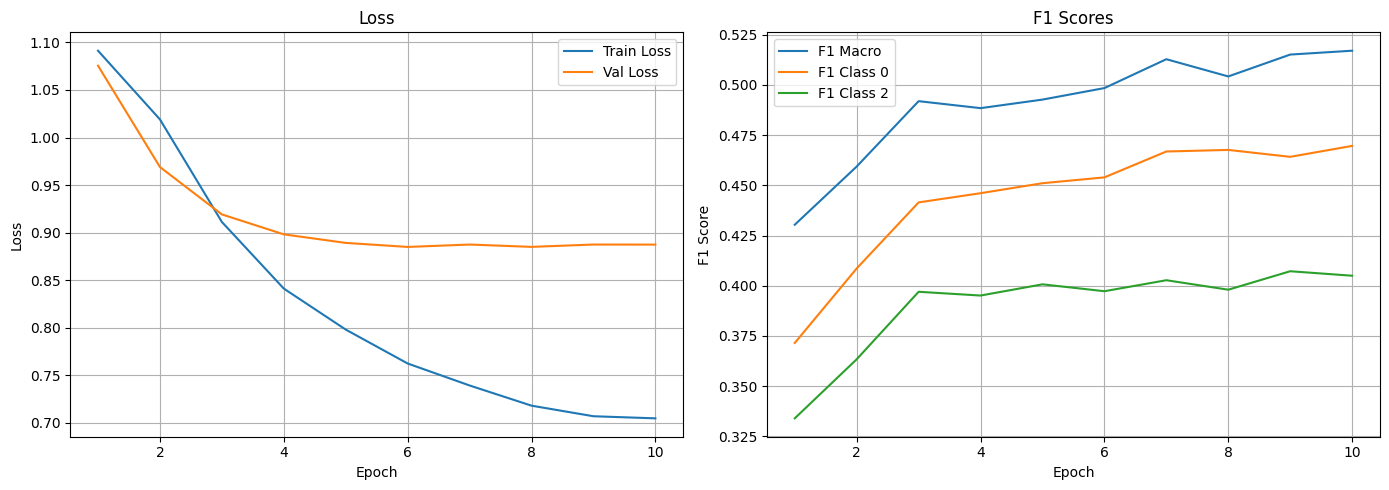

Testing: 100%|██████████| 54/54 [00:00<00:00, 152.17it/s]



Test F1 Macro: 0.5274

Classification Report:
               precision    recall  f1-score   support

           0     0.3457    0.7563    0.4745       197
           1     0.8840    0.5461    0.6752       921
           2     0.3416    0.5890    0.4324       163

    accuracy                         0.5839      1281
   macro avg     0.5238    0.6305    0.5274      1281
weighted avg     0.7322    0.5839    0.6134      1281


Accuracy per entity_tag:
  PROFESSION: 0.6215
  PERSON: 0.6211
  COUNTRY: 0.5193
  NATIONALITY: 0.4912
  ORGANIZATION: 0.5646
Model saved to ./baseline_TSA/


In [4]:
trainer = RuBertCLSTrainer(
    train_path='/content/upd_train_TSA_SA.csv',
    val_path='/content/upd_val_TSA_SA.csv',
    test_path='/content/upd_test_TSA_SA.csv',
    add_token=False
)

trainer.train()
trainer.test()
trainer.save_model('./baseline_TSA/')


## Model tuned on texts with [TAR] and with CLS hidden states (like T-BERT marked):

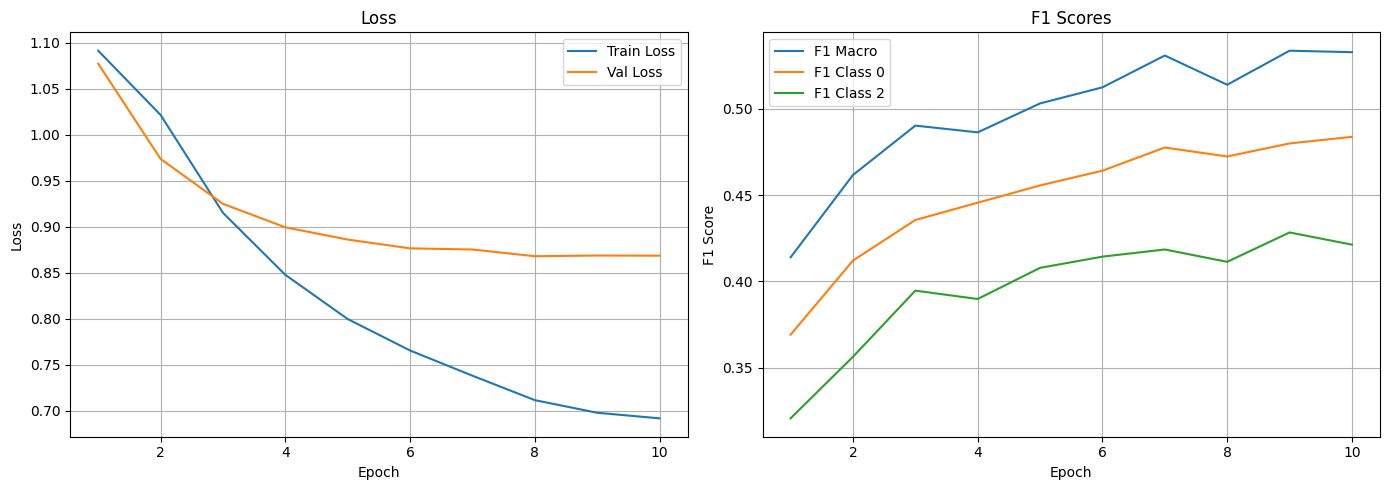

Testing: 100%|██████████| 54/54 [00:00<00:00, 140.91it/s]



Test F1 Macro: 0.5415

Classification Report:
               precision    recall  f1-score   support

           0     0.3676    0.7614    0.4959       197
           1     0.8883    0.5613    0.6880       921
           2     0.3436    0.6135    0.4405       163

    accuracy                         0.5988      1281
   macro avg     0.5332    0.6454    0.5415      1281
weighted avg     0.7389    0.5988    0.6269      1281


Accuracy per entity_tag:
  PROFESSION: 0.6625
  PERSON: 0.6132
  COUNTRY: 0.5408
  NATIONALITY: 0.5088
  ORGANIZATION: 0.5748
Model saved to ./cls_tar_TSA/


In [5]:
trainer = RuBertCLSTrainer(
    train_path='/content/upd_train_TSA_SA.csv',
    val_path='/content/upd_val_TSA_SA.csv',
    test_path='/content/upd_test_TSA_SA.csv',
    use_tar=True,
    add_token=True
)

trainer.train()
trainer.test()
trainer.save_model('./cls_tar_TSA/')

## Model tuned on texts with [TAR] and with the first [TAR] hidden state (like T-BERT marked-TS):

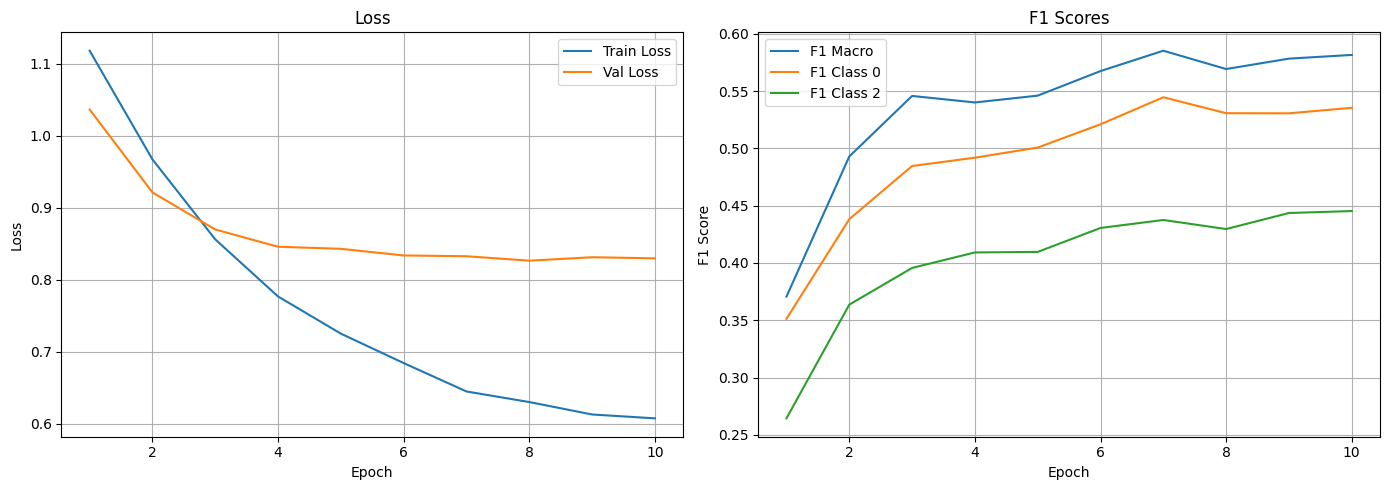

Testing: 100%|██████████| 54/54 [00:00<00:00, 145.14it/s]



Test F1 Macro: 0.5964

Classification Report:
               precision    recall  f1-score   support

           0     0.4282    0.7716    0.5507       197
           1     0.9148    0.6526    0.7617       921
           2     0.3829    0.6319    0.4769       163

    accuracy                         0.6682      1281
   macro avg     0.5753    0.6853    0.5964      1281
weighted avg     0.7723    0.6682    0.6930      1281


Accuracy per entity_tag:
  PROFESSION: 0.8233
  PERSON: 0.5526
  COUNTRY: 0.6738
  NATIONALITY: 0.6491
  ORGANIZATION: 0.6497
Model saved to ./tar_tar_TSA/


In [6]:
trainer = RuBertCLSTrainer(
    train_path='/content/upd_train_TSA_SA.csv',
    val_path='/content/upd_val_TSA_SA.csv',
    test_path='/content/upd_test_TSA_SA.csv',
    model_name='cointegrated/rubert-tiny2',
    add_token=True,
    use_tar=True,
    use_tar_emb=True,
)

trainer.train()
trainer.test()
trainer.save_model('./tar_tar_TSA/')